# Adsorbates on a Square Lattice in the Grand Canonical Ensemble

In [1]:
using FreeBird
using Plots
using DataFrames
using CSV
using Distributions

In [17]:
df_microstates = CSV.read("data/microstates_exact_square_L4_M4_adsorption-0.04_nn-0.01_nnn-0.0025_cutoff1.1_1.5.csv", DataFrame)

# Add a row at the beginning for N=0
df_microstates = vcat(DataFrame(N=0, L=4, M=4, energy=0, configurations=""), df_microstates)

# Add a column for the energy relative to the minimum energy
minimum_energy = minimum(df_microstates[!, :energy])
df_microstates[!, :energy_relative] = df_microstates[!, :energy] .- minimum_energy

# Print the first few rows
first(df_microstates, 5)

Row,N,L,M,energy,configurations,energy_relative
,Int64,Int64,Int64,Float64,String,Float64
1,0,4,4,0.0,,1.04
2,1,4,4,-0.04,"LatticeSystem([1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0], [0.0 0.0 0.0; 1.0 0.0 0.0; 2.0 0.0 0.0; 3.0 0.0 0.0; 0.0 1.0 0.0; 1.0 1.0 0.0; 2.0 1.0 0.0; 3.0 1.0 0.0; 0.0 2.0 0.0; 1.0 2.0 0.0; 2.0 2.0 0.0; 3.0 2.0 0.0; 0.0 3.0 0.0; 1.0 3.0 0.0; 2.0 3.0 0.0; 3.0 3.0 0.0], (4, 4, 1), Bool[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [([2, 4, 5, 13], [6, 8, 14, 16]), ([1, 3, 6, 14], [5, 7, 13, 15]), ([2, 4, 7, 15], [6, 8, 14, 16]), ([1, 3, 8, 16], [5, 7, 13, 15]), ([1, 6, 8, 9], [2, 4, 10, 12]), ([2, 5, 7, 10], [1, 3, 9, 11]), ([3, 6, 8, 11], [2, 4, 10, 12]), ([4, 5, 7, 12], [1, 3, 9, 11]), ([5, 10, 12, 13], [6, 8, 14, 16]), ([6, 9, 11, 14], [5, 7, 13, 15]), ([7, 10, 12, 15], [6, 8, 14, 16]), ([8, 9, 11, 16], [5, 7, 13, 15]), ([1, 9, 14, 16], [2, 4, 10, 12]), ([2, 10, 13, 15], [1, 3, 9, 11]), ([3, 11, 14, 16], [2, 4, 10, 12]), ([4, 12, 13, 15], [1, 3, 9, 11])], Bool[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])",1.0
3,1,4,4,-0.04,"LatticeSystem([1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0], [0.0 0.0 0.0; 1.0 0.0 0.0; 2.0 0.0 0.0; 3.0 0.0 0.0; 0.0 1.0 0.0; 1.0 1.0 0.0; 2.0 1.0 0.0; 3.0 1.0 0.0; 0.0 2.0 0.0; 1.0 2.0 0.0; 2.0 2.0 0.0; 3.0 2.0 0.0; 0.0 3.0 0.0; 1.0 3.0 0.0; 2.0 3.0 0.0; 3.0 3.0 0.0], (4, 4, 1), Bool[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [([2, 4, 5, 13], [6, 8, 14, 16]), ([1, 3, 6, 14], [5, 7, 13, 15]), ([2, 4, 7, 15], [6, 8, 14, 16]), ([1, 3, 8, 16], [5, 7, 13, 15]), ([1, 6, 8, 9], [2, 4, 10, 12]), ([2, 5, 7, 10], [1, 3, 9, 11]), ([3, 6, 8, 11], [2, 4, 10, 12]), ([4, 5, 7, 12], [1, 3, 9, 11]), ([5, 10, 12, 13], [6, 8, 14, 16]), ([6, 9, 11, 14], [5, 7, 13, 15]), ([7, 10, 12, 15], [6, 8, 14, 16]), ([8, 9, 11, 16], [5, 7, 13, 15]), ([1, 9, 14, 16], [2, 4, 10, 12]), ([2, 10, 13, 15], [1, 3, 9, 11]), ([3, 11, 14, 16], [2, 4, 10, 12]), ([4, 12, 13, 15], [1, 3, 9, 11])], Bool[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])",1.0
4,1,4,4,-0.04,"LatticeSystem([1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0], [0.0 0.0 0.0; 1.0 0.0 0.0; 2.0 0.0 0.0; 3.0 0.0 0.0; 0.0 1.0 0.0; 1.0 1.0 0.0; 2.0 1.0 0.0; 3.0 1.0 0.0; 0.0 2.0 0.0; 1.0 2.0 0.0; 2.0 2.0 0.0; 3.0 2.0 0.0; 0.0 3.0 0.0; 1.0 3.0 0.0; 2.0 3.0 0.0; 3.0 3.0 0.0], (4, 4, 1), Bool[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [([2, 4, 5, 13], [6, 8, 14, 16]), ([1, 3, 6, 14], [5, 7, 13, 15]), ([2, 4, 7, 15], [6, 8, 14, 16]), ([1, 3, 8, 16], [5, 7, 13, 15]), ([1, 6, 8, 9], [2, 4, 10, 12]), ([2, 5, 7, 10], [1, 3, 9, 11]), ([3, 6, 8, 11], [2, 4, 10, 12]), ([4, 5, 7, 12], [1, 3, 9, 11]), ([5, 10, 12, 13], [6, 8, 14, 16]), ([6, 9, 11, 14], [5, 7, 13, 15]), ([7, 10, 12, 15], [6, 8, 14, 16]), ([8, 9, 11, 16], [5, 7, 13, 15]), ([1, 9, 14, 16], [2, 4, 10, 12]), ([2, 10, 13, 15], [1, 3, 9, 11]), ([3, 11, 14, 16], [2, 4, 10, 12]), ([4, 12, 13, 15], [1, 3, 9, 11])], Bool[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])",1.0
5,1,4,4,-0.04,"LatticeSystem([1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0], [0.0 0.0 0.0; 1.0 0.0 0.0; 2.0 0.0 0.0; 3.0 0.0 0.0; 0.0 1.0 0.0; 1.0 1.0 0.0; 2.0 1.0 0.0; 3.0 1.0 0.0; 0.0 2.0 0.0; 1.0 2.0 0.0; 2.0 2.0 0.0; 3.0 2.0 0.0; 0.0 3.0 0.0; 1.0 3.0 0.0; 2.0 3.0 0.0; 3.0 3.0 0.0], (4, 4, 1), Bool[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [([2, 4, 5, 13], [6, 8, 14, 16]), ([1, 3, 6, 14], [5, 7, 13, 15]), ([2, 4, 7, 15], [6, 8, 14, 16]), ([1, 3, 8, 16], [5, 7, 13, 15]), ([1, 6, 8, 9], [2, 4, 10, 12]), ([2, 5, 7, 10], [1, 3, 9, 11]), ([3, 6, 8, 11], [2, 4, 10, 12]), ([4, 5, 7, 12], [1, 3, 9, 11]), ([5, 10, 12, 13], [6, 8, 14, 16]), ([6, 9, 11, 14], [5, 7, 13, 15]), ([7, 10, 12, 15], [6, 8, 14, 16]), ([8, 9, 11, 16], [5, 7, 13, 15]), ([1, 9, 14, 16], [2, 4, 10, 12]), ([2, 10, 13, 15], [1, 3, 9, 11]), ([3, 11, 14, 16], [2, 4, 10, 12]), ([4, 12, 13, 15], [1, 3, 9, 11])], Bool[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])",1.0


## Thermodynamics

### Ensemble Average of the Number of Adsorbates

$ \mu = \varepsilon_{\mathrm{ads}} = 4 \varepsilon_{\mathrm{NN}} $

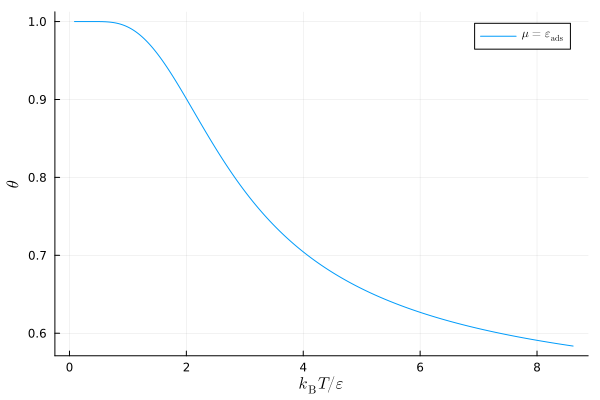

In [45]:
Ns = unique(df_microstates.N)
Ts = collect(1:1:1000)
βs = 1 ./ (k_B .* Ts)
μ = -0.04

# Loop over all (N, E) pairs
Z = zeros(length(βs))
numerator = zeros(length(βs))
for N in Ns
    df_microstates_N = deepcopy(df_microstates[df_microstates.N .== N, :])

    # Compute the grand potential
    E = deepcopy(df_microstates_N.energy_relative)
    Ω = E .- μ * N

    # Compute the exponential of minus β multiplied by the grand potential
    Z_N = zeros(length(βs))
    numerator_N = zeros(length(βs))
    for (i, β) in enumerate(βs)
        Z_N[i] = sum(exp.(-β .* Ω))
        numerator_N[i] = sum(exp.(-β .* Ω) .* N)
    end

    # Add the contribution of this (N, E) pair to the grand partition function
    Z .+= Z_N
    numerator .+= numerator_N
end

# Compute the ensemble average of the coverage
θ = numerator ./ Z / Ns[end]

# Plot the average number of particles
plot(Ts .* (k_B / 0.01), θ, label="\$ \\mu = \\varepsilon_{\\mathrm{ads}} \$", xlabel="\$ k_{\\mathrm{B}} T / \\varepsilon \$", ylabel="\$ \\theta \$")

### Ensemble Average of the Number of Adsorbates as a Function of the Chemical Potential

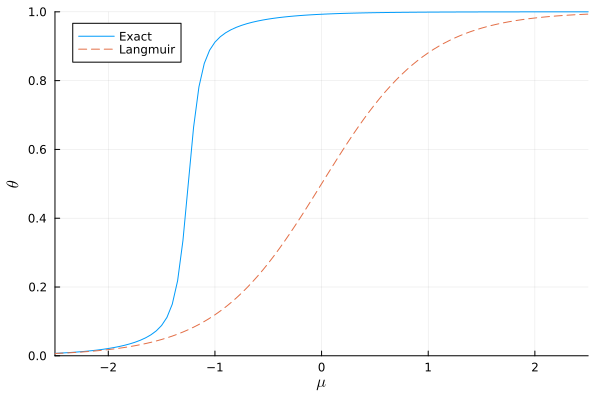

In [83]:
Ns = unique(df_microstates.N)
T_star = 1
Ts = [T_star * 0.01 / k_B]
βs = 1 ./ (k_B .* Ts)
μs = collect(-0.1:0.001:0.1)

# Loop over all μ values
N_avgs = zeros(length(μs))
for (i, μ) in enumerate(μs)
    
    # Loop over all (N, E) pairs
    Z = zeros(length(βs))
    numerator = zeros(length(βs))
    for N in Ns
        df_microstates_N = deepcopy(df_microstates[df_microstates.N .== N, :])

        # Compute the grand potential
        E = deepcopy(df_microstates_N.energy)
        Ω = E .- μ * N

        # Compute the exponential of minus β multiplied by the grand potential
        Z_N = zeros(length(βs))
        numerator_N = zeros(length(βs))
        for (i, β) in enumerate(βs)
            Z_N[i] = sum(exp.(-β .* Ω))
            numerator_N[i] = sum(exp.(-β .* Ω) .* N)
        end

        # Add the contribution of this (N, E) pair to the grand partition function
        Z .+= Z_N
        numerator .+= numerator_N
    end

    # Compute the average number of particles
    N_avg = numerator ./ Z

    # Store the average number of particles
    N_avgs[i] = N_avg[1]
end

# Compute the ensemble average of the coverage
θ = N_avgs ./ 16

# Compute Langmuir coverage
θ_langmuir = exp.(βs[1] * μs) ./ (1 .+ exp.(βs[1] * μs))

# Plot the average number of particles
plot((μs .+ 0.04) ./ (2 * k_B * Ts[1]), θ, label="Exact", xlabel="\$ \\mu \$", ylabel="\$ \\theta \$")
plot!(μs ./ (2 * k_B * Ts[1]), θ_langmuir, label="Langmuir", linestyle=:dash)
plot!(xlims=(-2.5, 2.5), ylims=(0, 1))

### Ensemble Average of the Number of Adsorbates as a Function of the Chemical Potential and Temperature

In [88]:
Ns = unique(df_microstates.N)
T_stars = collect(0.1:0.1:1.5)
Ts = T_stars .* 0.01 / k_B
βs = 1 ./ (k_B .* Ts)
μs = collect(-0.1:0.01:0.1)

21-element Vector{Float64}:
 -0.1
 -0.09
 -0.08
 -0.07
 -0.06
 -0.05
 -0.04
 -0.03
 -0.02
 -0.01
  ⋮
  0.02
  0.03
  0.04
  0.05
  0.06
  0.07
  0.08
  0.09
  0.1